In [1]:
import math
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import cv2
import skimage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import listdir

In [2]:
import tensorflow.python.platform
from keras.preprocessing import sequence
from collections import Counter

from keras import models
# from keras.applications.vgg16 import preprocess_input
# from keras.applications.vgg16 import VGG16
from keras.preprocessing import image as keras_image

Using TensorFlow backend.


In [3]:
model_path = './models/tensorflow/'
#image_path = './data/test_images/'
image_path = '../Project/data/flickr30k_images/'
glove_path = './data/glove_embedding.npy'
vgg_path = './data/vgg16-20160129.tfmodel'
dest_path = './data/outputs'

In [5]:
# base_model = VGG16(weights='imagenet')
# vgg_model = models.Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

In [4]:
def load_glove_model(glove_path):
    return np.load(glove_path,'r')

In [5]:
dim_embed = 100
dim_hidden = 256
dim_in = 4096
batch_size = 1

In [6]:
class Caption_Generator():
    def __init__(self, dim_in, dim_hidden, dim_embed, batch_size, n_lstm_steps, n_words,glove_embedding, init_b=None):

        self.dim_in = dim_in
        self.dim_embed = dim_embed
        self.dim_hidden = dim_hidden
        self.batch_size = batch_size
        self.n_lstm_steps = n_lstm_steps
        self.n_words = n_words
        self.glove_embedding = np.array(glove_embedding).astype(np.float32)
        
        # declare the variables to be used for our word embeddings
        with tf.device("/cpu:0"):
            self.glove_embedding = tf.Variable(tf.convert_to_tensor(glove_embedding, np.float32), name='glove_embedding') 

        self.embedding_bias = tf.Variable(tf.zeros([dim_embed]), name='embedding_bias')
        
        # declare the LSTM itself
        self.lstm = tf.contrib.rnn.BasicLSTMCell(dim_hidden)
        
        # declare the variables to be used to embed the image feature embedding to the word embedding space
        self.img_embedding = tf.Variable(tf.random_uniform([dim_in, dim_embed], -0.1, 0.1), name='img_embedding')
        self.img_embedding_bias = tf.Variable(tf.zeros([dim_embed]), name='img_embedding_bias')

        # declare the variables to go from an LSTM output to a word encoding output
        self.word_encoding = tf.Variable(tf.random_uniform([dim_hidden, n_words], -0.1, 0.1), name='word_encoding')
        
        # optional initialization setter for encoding bias variable 
        if init_b is not None:
            self.word_encoding_bias = tf.Variable(init_b, name='word_encoding_bias')
        else:
            self.word_encoding_bias = tf.Variable(tf.zeros([n_words]), name='word_encoding_bias')


    def build_generator(self, maxlen, batchsize=1):
        #same setup as `build_model` function 
        img = tf.placeholder(tf.float32, [self.batch_size, self.dim_in])
        image_embedding = tf.matmul(img, self.img_embedding) + self.img_embedding_bias
        state = self.lstm.zero_state(batchsize,dtype=tf.float32)

        #declare list to hold the words of our generated captions
        all_words = []
        with tf.variable_scope("RNN"):
            # in the first iteration we have no previous word, so we directly pass in the image embedding
            # and set the `previous_word` to the embedding of the start token ([0]) for the future iterations
            output, state = self.lstm(image_embedding, state)
            previous_word = tf.nn.embedding_lookup(self.glove_embedding, [0]) + self.embedding_bias

            for i in range(maxlen):
                tf.get_variable_scope().reuse_variables()

                out, state = self.lstm(previous_word, state)
                # get a one-hot word encoding from the output of the LSTM
                logit = tf.matmul(out, self.word_encoding) + self.word_encoding_bias
                best_word = tf.argmax(logit, 1)

                with tf.device("/cpu:0"):
                    # get the embedding of the best_word to use as input to the next iteration of our LSTM 
                    previous_word = tf.nn.embedding_lookup(self.glove_embedding, best_word)

                previous_word += self.embedding_bias

                all_words.append(best_word)

        return img, all_words

In [7]:
if not os.path.exists('data/ixtoword.npy'):
    print ('Do Training First')
else:
    tf.reset_default_graph()
    with open(vgg_path,'rb') as f:
        fileContent = f.read()
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(fileContent)

    images = tf.placeholder("float32", [1, 224, 224, 3])
    tf.import_graph_def(graph_def, input_map={"images":images})
    
    ixtoword = np.load('data/ixtoword.npy').tolist()
    n_words = len(ixtoword)
    glove_embeddings = load_glove_model(glove_path)
    maxlen=25
    graph = tf.get_default_graph()
    sess = tf.InteractiveSession(graph=graph)
    caption_generator = Caption_Generator(dim_in, dim_hidden, dim_embed, batch_size, maxlen+2, n_words,glove_embeddings)
    graph = tf.get_default_graph()    
    image, generated_words = caption_generator.build_generator(maxlen=maxlen)


In [8]:
def features(img_path):
    img = keras_image.load_img(img_path, target_size=(224, 224))
    x = keras_image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    print(x.shape)
    #x = preprocess_input(x)

    #fc2_features = vgg_model.predict(x)
    #return fc2_features
    return x


In [9]:
def crop_image(x, target_height=227, target_width=227, as_float=True):
    image = cv2.imread(x)
    if as_float:
        image = image.astype(np.float32)

    if len(image.shape) == 2:
        image = np.tile(image[:,:,None], 3)
    elif len(image.shape) == 4:
        image = image[:,:,:,0]

    height, width, rgb = image.shape
    if width == height:
        resized_image = cv2.resize(image, (target_height,target_width))

    elif height < width:
        resized_image = cv2.resize(image, (int(width * float(target_height)/height), target_width))
        cropping_length = int((resized_image.shape[1] - target_height) / 2)
        resized_image = resized_image[:,cropping_length:resized_image.shape[1] - cropping_length]

    else:
        resized_image = cv2.resize(image, (target_height, int(height * float(target_width) / width)))
        cropping_length = int((resized_image.shape[0] - target_width) / 2)
        resized_image = resized_image[cropping_length:resized_image.shape[0] - cropping_length,:]

    return cv2.resize(resized_image, (target_height, target_width))

In [10]:
def read_image(path):

     img = crop_image(path, target_height=224, target_width=224)
     if img.shape[2] == 4:
         img = img[:,:,:3]

     img = img[None, ...]
     return img

In [12]:
def test(sess,generated_words,ixtoword, image_path): # Naive greedy search

    disp_flag = True
#     feat = np.zeros((1,4096))
#     for i in files[:10]:
#         feat = np.vstack((feat,features(vgg_model,image_path+i)))
    feat = np.zeros((1, 4096))
    for test_img in os.listdir(image_path)[5000:5010]:
        img = read_image(os.path.join(image_path, test_img))
        feat = np.vstack((feat, sess.run(graph.get_tensor_by_name("import/Relu_1:0"), feed_dict={images:img})))
    feat = feat[1:]
    #feat = np.load('./data/image_features.npy','r')
    orig_feat = np.load('./data/feats.npy','r')[5000*5:5010*5:5]
    #print(feat[0][:10])
    #print(orig_feat[0][:10])
    
    img_file_name = os.listdir(image_path)[5000:5010]
    #img_file_name = os.listdir('../Project/data/flickr30k_images')[:20]
    #print(img_file_name)
    #image_path = '../Project/data/flickr30k_images'
    saver = tf.train.Saver()
    
    sanity_check=False
    if not sanity_check:
        saved_path=tf.train.latest_checkpoint(model_path)
        saver.restore(sess, saved_path)
    else:
        tf.global_variables_initializer().run()
    
    print(len(feat))
    for index,f in enumerate(orig_feat):
        generated_word_index= sess.run(generated_words, feed_dict={image:np.reshape(f,(1,4096))})
        generated_word_index = np.hstack(generated_word_index)
        output_words = [ixtoword[x] for x in generated_word_index]
        punctuation = np.argmax(np.array(output_words) == '.')+1
        if(punctuation == 1):
            punctuation = maxlen
        output_words_final = output_words[:punctuation]
        generated_sentence = ' '.join(output_words_final)
        # Display the image
        if disp_flag:
            img=mpimg.imread(os.path.join(image_path,img_file_name[index]))
            imgplot = plt.imshow(img)
            plt.axis('off')
            plt.title(generated_sentence)
            plt.savefig(os.path.join(dest_path,img_file_name[index])+".png", bbox_inches='tight')
            plt.show()
            #print('Generated Caption:', generated_sentence)
            #print('Generated Words:', output_words)

INFO:tensorflow:Restoring parameters from ./models/tensorflow/model-0
10


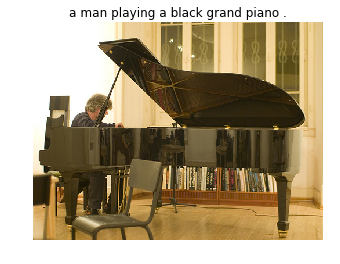

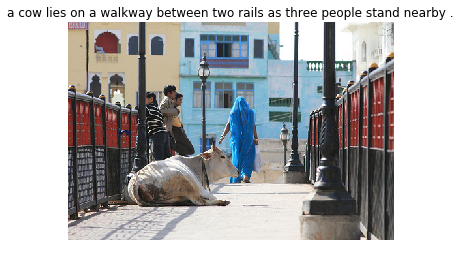

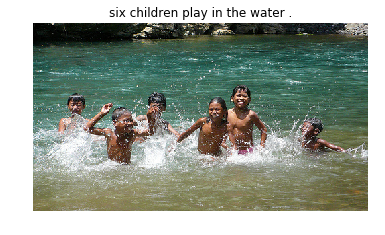

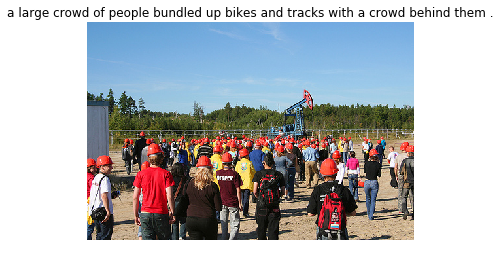

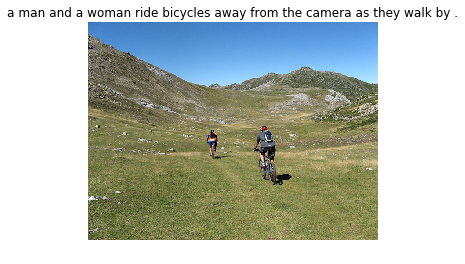

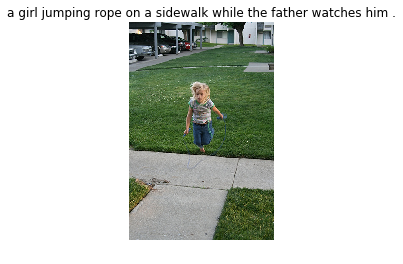

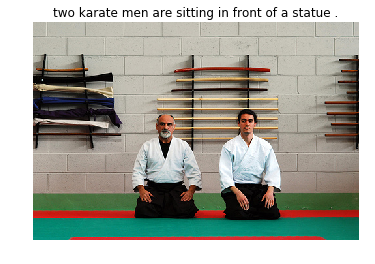

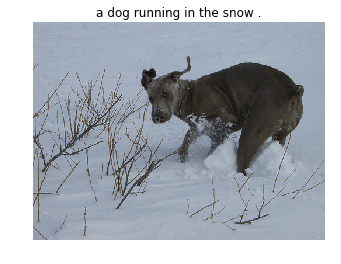

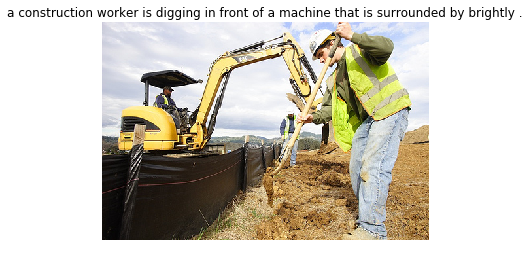

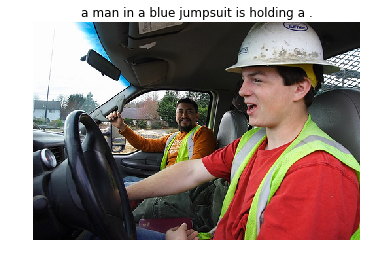

In [14]:
test(sess,generated_words,ixtoword, image_path)